# Part 1. Supervised ML

In [1]:
# import libraries

from sklearn.linear_model import LogisticRegression

from sklearn.compose import ColumnTransformer

from sklearn.tree import DecisionTreeClassifier

from sklearn.ensemble import RandomForestClassifier

from sklearn.svm import SVC

from sklearn.neighbors import KNeighborsClassifier

from sklearn.preprocessing import StandardScaler, OneHotEncoder

from sklearn.model_selection import GridSearchCV, train_test_split, cross_val_score

from sklearn.pipeline import make_pipeline

from sklearn.compose import make_column_transformer, make_column_selector

from sklearn.impute import SimpleImputer 

import pandas as pd

import numpy as np

from sklearn.metrics import precision_score, recall_score, accuracy_score

from sklearn.model_selection import RepeatedStratifiedKFold

from sklearn.feature_selection import RFE


In [3]:
pd.options.display.max_rows = None
pd.options.display.max_columns = None

## Cleaning the data

In [2]:
# load the two datasets
soil = pd.read_csv("soil_data.csv")
weather = pd.read_csv("train_timeseries.csv")

#concat them and draw a sample
conc = pd.merge(left = weather, right=soil)
sample = conc.sample(n = 100000)

sample.reset_index(inplace = True)

new_sample = sample.copy()
new_sample['date'] = pd.to_datetime(new_sample['date'])
new_sample = new_sample.groupby(['date','fips']).mean()

# group by date, as dataframe contains multiple values for the same date, and add the weekly drought score to
# all days that week
df = new_sample.reset_index().drop("fips", axis = 1)
df.sort_values(by="date", inplace = True)
df.score = df.score.fillna(method = "backfill")
df = df.groupby("date").mean()
df.score = df.score.fillna(method = "ffill")

# replace float drought scores with the D0-D4 scale
def myfunc(x):
    if x < 1:
        return "No drought"
    elif x > 0.9999 and x < 2:
        return "D0"
    elif x > 1.9999 and x < 3:
        return "D1"
    elif x > 2.9999 and x < 4:
        return "D2"
    elif x > 3.9999 and x < 5:
        return "D3"
    elif x == 5:
        return "D4"

df.score = df.score.apply(myfunc)

df.drop("index", axis = 1, inplace = True)

## Splitting data

In [5]:
df_test = df[['PRECTOT','PS', 'QV2M', 'T2M', 'T2MDEW', 'T2MWET', 'T2M_MAX',
       'T2M_MIN', 'T2M_RANGE', 'TS', 'lat', 'lon', 'elevation', 'SQ1', 'SQ2', 'score']]

In [6]:
# the data came in two files: test and train. This is the train file, but we will split it anyway for an extra
# training set (validation)

target = "score"

X = df_test.drop(target, axis = 1)
y = df_test[target]

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 42)

## Creating dummies to make the baseline

In [7]:
from sklearn.dummy import DummyClassifier

dummy = DummyClassifier()

dummy.fit(X_train, y_train)

baseline = dummy.score(X_train, y_train)
print(f"The baseline to beat is an accuracy of {baseline}")

The baseline to beat is an accuracy of 0.6894996779042302


## Making the model

In [8]:
num_cols = X.select_dtypes("number").columns
num_trans = make_pipeline(StandardScaler())

cat_cols = X.select_dtypes("object").columns
encoder = OneHotEncoder(drop = "if_binary", handle_unknown= "ignore")
col_trans = make_pipeline(
    encoder
    )

preprocessor = make_column_transformer((num_trans, num_cols),(col_trans, cat_cols))

classifiers = [LogisticRegression(max_iter = 1000), 
              DecisionTreeClassifier(),
              RandomForestClassifier(),
              SVC(),
              KNeighborsClassifier()]

for classifier in classifiers:
    pipe = make_pipeline(preprocessor, classifier)
    grid = GridSearchCV(estimator = pipe, param_grid = {}, cv = 5, scoring = "accuracy")
    grid.fit(X_train, y_train)
    
    print(f"Train score for {classifier}: {grid.best_score_}")
    print("")

Train score for LogisticRegression(max_iter=1000): 0.6897145530902671

Train score for DecisionTreeClassifier(): 0.5067641513348053

Train score for RandomForestClassifier(): 0.6849914485785279

Train score for SVC(): 0.6894997303190533

Train score for KNeighborsClassifier(): 0.6235811785748859



In [9]:
# Tuning hyperparams for chosen classifier (LogReg)

clf = LogisticRegression(max_iter = 1000)
pipe = make_pipeline(preprocessor, clf)
c_params = {"logisticregression__C":[0.0001]}

grid = GridSearchCV(pipe, param_grid = c_params, cv = 5) #tunes hyperparam and crossval


grid.fit(X_train, y_train)
pipe.fit(X_train, y_train)

y_true = y_train

y_pred = pipe.predict(X_train)

print("Precision Score : ",precision_score(y_train,y_pred,average = "micro"))
print("Recall Score :" , recall_score(y_train, y_pred, average = "micro") )
print("Accuracy score:" , accuracy_score(y_train, y_pred))

Precision Score :  0.689929138930642
Recall Score : 0.689929138930642
Accuracy score: 0.689929138930642


## Test model

In [10]:
grid = GridSearchCV(pipe, param_grid = c_params, cv = 5)
grid.fit(X_test, y_test)
grid.score(X_test, y_test)

0.6857694784288474

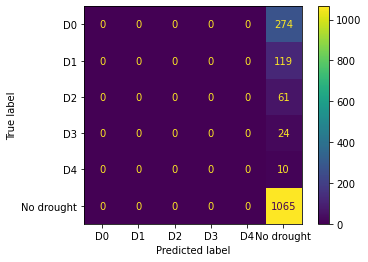

In [11]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

pred = grid.predict(X_test)
cm = confusion_matrix(y_test, pred)

ConfusionMatrixDisplay(confusion_matrix=cm, display_labels = grid.classes_).plot()

In [12]:
from sklearn import metrics, model_selection

In [13]:
# refitting the model on all our data

model = make_pipeline(preprocessor, LogisticRegression(C = 0.001))
model.fit(X, y)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('pipeline-1',
                                                  Pipeline(steps=[('standardscaler',
                                                                   StandardScaler())]),
                                                  Index(['PRECTOT', 'PS', 'QV2M', 'T2M', 'T2MDEW', 'T2MWET', 'T2M_MAX',
       'T2M_MIN', 'T2M_RANGE', 'TS', 'lat', 'lon', 'elevation', 'SQ1', 'SQ2'],
      dtype='object')),
                                                 ('pipeline-2',
                                                  Pipeline(steps=[('onehotencoder',
                                                                   OneHotEncoder(drop='if_binary',
                                                                                 handle_unknown='ignore'))]),
                                                  Index([], dtype='object'))])),
                ('logisticregression', LogisticRegression(C=0.00

In [14]:
from joblib import dump

In [15]:
# serialize our model to our harddrive for future use

dump(model, "drought_model.joblib")

['drought_model.joblib']

# Part 2. Visualizing

In [17]:
# grouping dates into years
df.reset_index(inplace = True)
df["year"] = df.date.dt.year

# turning classes numerical for simplicity in graphs
def myfunc(x):
    if x == "No drought":
        return 0
    elif x == "D0":
        return 1
    elif x == "D1":
        return 2
    elif x == "D2":
        return 3
    elif x == "D3":
        return 4
    elif x == "D4":
        return 5
df.score = df.score.apply(myfunc)

new_sample = new_sample.reset_index()

In [18]:
# turn fips codes into states
# this info is later extracted to create a map using QGIS

def states(x):
    if x in range(1001,2013):
        return "Alabama"
    elif x in range(4001,4027):
        return "Arizona"
    elif x in range(5001, 5149):
        return "Arkansas"
    elif x in range(6001,6115):
        return "California"
    elif x in range(8001,8125):
        return "Colorado"
    elif x in range(9001, 9015):
        return "Connecticut"
    elif x in range(10001, 10005):
        return "Delaware"
    elif x == 11001:
        return "District of Columbia"
    elif x in range(12001,12133):
        return "Florida"
    elif x in range(13001, 13321):
        return "Georgia"
    elif x in range(16001,16087):
        return "Idaho"
    elif x in range(17001, 17203):
        return "Illinois"
    elif x in range(18001, 18183):
        return "Indiana"
    elif x in range(19001, 19195):
        return "Iowa"
    elif x in range(20001, 20209):
        return "Kansas"
    elif x in range(21001,21239):
        return "Kentucky"
    elif x in range(22001, 22127):
        return "Louisiana"
    elif x in range(23001,23031):
        return "Maine"
    elif x in range(24001,24510):
        return "Maryland"
    elif x in range(25001, 25027):
        return "Massachusetts"
    elif x in range(26001,26165):
        return "Michigan"
    elif x in range(27001,27173):
        return "Minnesota"
    elif x in range(28001, 28163):
        return "Mississippi"
    elif x in range(29001,29510):
        return "Missouri"
    elif x in range(30001,30113):
        return "Montana"
    elif x in range(31001,31183):
        return "Nebraska"
    elif x in range(32001,32510):
        return "Nevada"
    elif x in range(33001,33019):
        return "New Hampshire"
    elif x in range(34001,34041):
        return "New Jersey"
    elif x in range(35001,35061):
        return "New Mexico"
    elif x in range(36001,36123):
        return "New York"
    elif x in range(37001,37199):
        return "North Carolina"
    elif x in range(38001,38105):
        return "North Dakota"
    elif x in range(39001,39175):
        return "Ohio"
    elif x in range(40001,40153):
        return "Oklahoma"
    elif x in range(41001,41071):
        return "Oregon"
    elif x in range(42001,42133):
        return "Philadelpia"
    elif x in range(44001,44009):
        return "Rhode Island"
    elif x in range(45001,45091):
        return "South Carolina"
    elif x in range(46003,46137):
        return "South Dakota"
    elif x in range(47001,47189):
        return "Tennessee"
    elif x in range(48001,48507):
        return "Texas"
    elif x in range(49001,49057):
        return "Utah"
    elif x in range(50001,50027):
        return "Vermont"
    elif x in range(51001,51840):
        return "Virginia"
    elif x in range(53001,53077):
        return "Washington"
    elif x in range(54001,54109):
        return "West Virginia"
    elif x in range(55001,55141):
        return "Wisconsin"
    elif x in range(56001,56045):
        return "Wyoming"

new_sample.fips = new_sample.fips.apply(states)
states = new_sample.groupby("fips")["score"].mean()
# turn into csv for importing into QGIS - no other work done in code here
states.to_csv("states.csv")